# Deploy fast.ai model

## Setup

In [1]:
%matplotlib inline
import os
import random
from io import BytesIO
import subprocess
from glob import glob

from PIL import Image
import requests
import boto3

import sagemaker
from sagemaker.predictor import RealTimePredictor, json_deserializer
from sagemaker.pytorch import PyTorchModel
from sagemaker.utils import name_from_image

In [ ]:
! if [ -e ~/.aws/credentials ]; then rm ~/.aws/credentials; fi

In [3]:
sagemaker_session = sagemaker.Session()

bucket_name = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-shirts-classification'

role = sagemaker.get_execution_role()

### Configure docker

Make sure docker is configured for local training 

In [4]:
%%bash
pushd utils
bash setup.sh
popd

~/SageMaker/sagemaker-fastai-example/utils ~/SageMaker/sagemaker-fastai-example
nvidia-docker2 already installed.
check if docker config the same
Files are the same. Ignoring
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!
~/SageMaker/sagemaker-fastai-example


## Host locally

### Create local model

The `PyTorch` model uses a npy serializer and deserializer by default. For this example, since we have a custom implementation of all the hosting functions and plan on using JSON instead, we need a predictor that can serialize and deserialize JSON.

In [5]:
class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=None, 
                                            deserializer=json_deserializer, content_type='image/jpeg')

Since hosting functions implemented outside of train script we can't just use estimator object to deploy the model. Instead we need to create a `PyTorchModel` object using the latest training job to get the S3 location of the trained model data. Besides model data location in S3, we also need to configure `PyTorchModel` with the script and source directory (because our `serve.py` script requires model and data classes from source directory), an IAM role.

In [15]:
%%bash

if [ ! -e ~/.aws/credentials ]; then
    echo "Writing new credentials file"
    accesskey=$(aws secretsmanager get-secret-value --secret-id "SageMakerNbAccessKey" --query 'SecretString' --output text)
    secretkey=$(aws secretsmanager get-secret-value --secret-id "SageMakerNbSecretKey" --query 'SecretString' --output text)

    cat > ~/.aws/credentials <<EOF
[default]
aws_access_key_id=${accesskey}
aws_secret_access_key=${secretkey}
EOF

else
    echo "Credentials file already exists"
fi

Writing new credentials file
Gracefully stopping... (press Ctrl+C again to force)


In [28]:
model = PyTorchModel(model_data='s3://sagemaker-eu-west-1-934676248949/fastai-shirts-2018-12-15-16-00-44-721/model.tar.gz',
                     role=role,
                     entry_point='src/shirts-jit/serve.py',
                     predictor_cls=ImagePredictor,
                     framework_version='1.0.0')

### Deploy model locally

We can now call `deploy()` with an instance_count and instance_type, which is `1` and `local`. This invokes our fast.ai container with `'serve'`, which setups our container to handle prediction requests as defined [here](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/serving.py#L103). What is returned is a predictor, which is used to make inferences against our trained model.

After our prediction, we can delete our endpoint.

We recommend testing and training your training algorithm locally first, as it provides quicker iterations and better debuggability.

In [29]:
predictor = model.deploy(initial_instance_count=1, instance_type='local')

INFO:sagemaker:Creating model with name: sagemaker-pytorch-2018-12-15-18-59-30-644
INFO:sagemaker:Creating endpoint with name sagemaker-pytorch-2018-12-15-18-59-30-644


Attaching to tmpo2ip1m7l_algo-1-DQ416_1
algo-1-DQ416_1  | 2018/12/15 18:59:37 [crit] 24#24: *1 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 172.18.0.1, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "localhost:8080"
algo-1-DQ416_1  | 172.18.0.1 - - [15/Dec/2018:18:59:37 +0000] "GET /ping HTTP/1.1" 502 182 "-" "-"
algo-1-DQ416_1  | [2018-12-15 18:59:37 +0000] [23] [INFO] Starting gunicorn 19.9.0
algo-1-DQ416_1  | [2018-12-15 18:59:37 +0000] [23] [INFO] Listening at: unix:/tmp/gunicorn.sock (23)
algo-1-DQ416_1  | [2018-12-15 18:59:37 +0000] [23] [INFO] Using worker: gevent
algo-1-DQ416_1  | [2018-12-15 18:59:37 +0000] [34] [INFO] Booting worker with pid: 34
algo-1-DQ416_1  | [2018-12-15 18:59:37 +0000] [42] [INFO] Booting worker with pid: 42
algo-1-DQ416_1  | [2018-12-15 18:59:37 +0000] [43] [INFO] Booting worker with pid: 43
algo-1-DQ416_1  | [2018-12-15 18:59:37 +0000] 

### Infer locally

Now we are ready to call our locally deployed endpoint to test it is working fine.

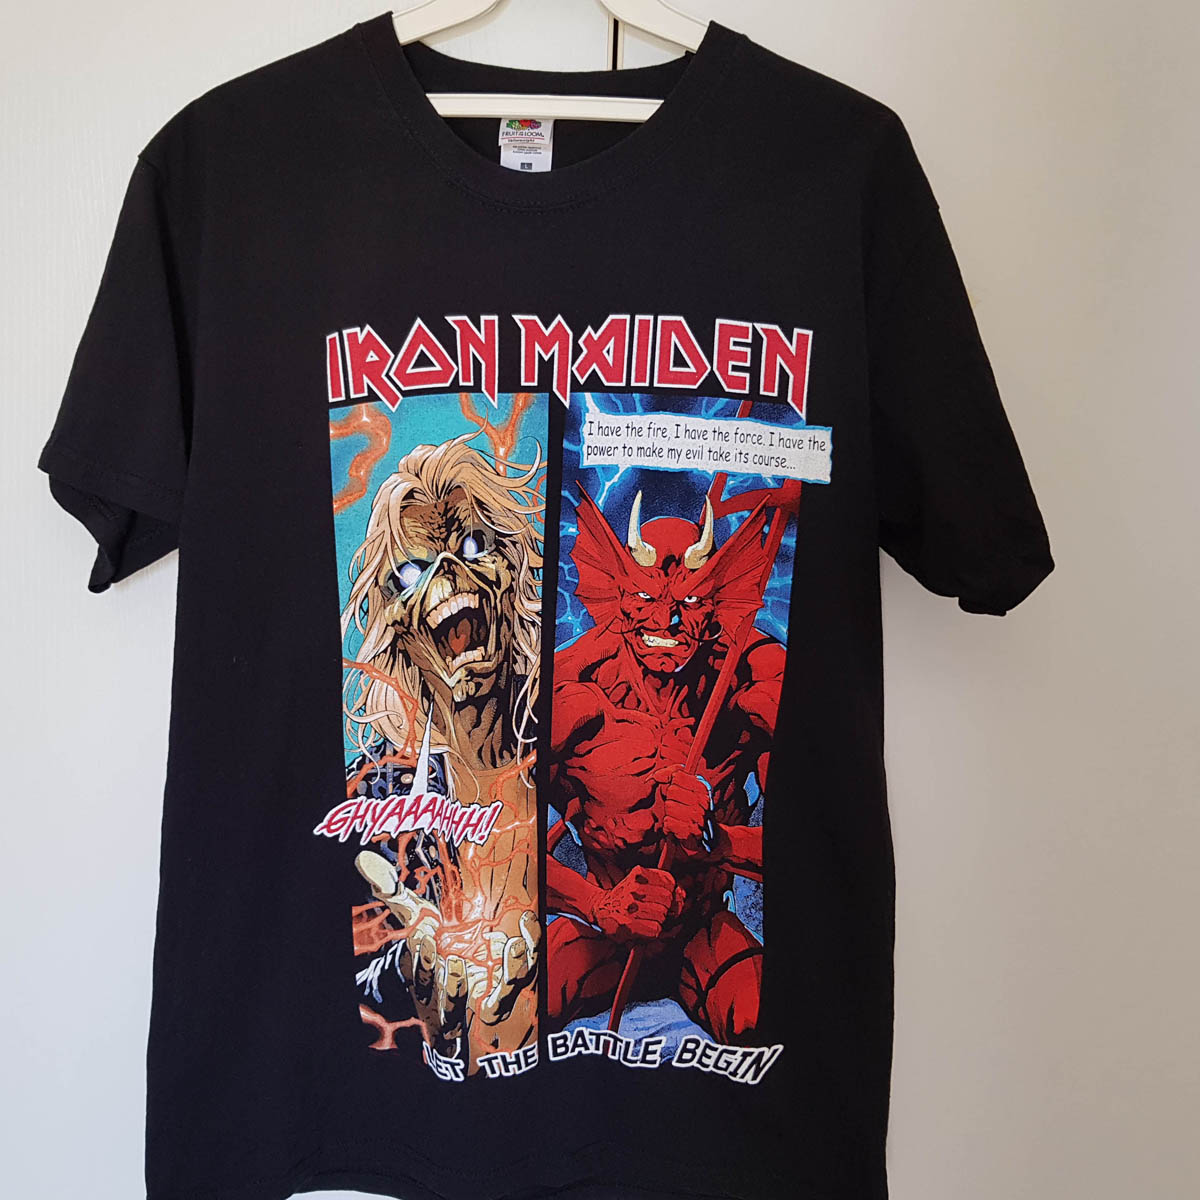

In [32]:
# Motorhead T-Shirt
#url = 'https://images.backstreetmerch.com/images/products/bands/clothing/mthd/bsi_mthd281.jpg'
# Judas Priest T-Shirt
#url = 'https://thumbs2.ebaystatic.com/d/l225/m/m7Lc1qRuFN3oFIlQla5V0IA.jpg'
# Iron Maiden T-Shirt
url = 'https://www.ironmaidencollector.com/assets/pages/ab9ed-20180815_121042.jpg'
# All Blacks rugby jersey
#url = 'https://images.sportsdirect.com/images/products/38153703_l.jpg'
# Australia Rugby T-Shirt
#url = 'https://www.lovell-rugby.co.uk/products/products_580x387/40378.jpg'
# Chicago Bulls top
#url = 'https://i.ebayimg.com/images/g/qc0AAOSwBahVN~qm/s-l300.jpg'
# Masters Golf Shirt
#url = 'https://s-media-cache-ak0.pinimg.com/originals/29/6a/15/296a15200e7dd3ed08e12d9052ea4f97.jpg'
img_bytes = requests.get(url).content
img = Image.open(BytesIO(img_bytes))
img

In [33]:
response = predictor.predict(img_bytes)
response

algo-1-DQ416_1  | 2018-12-15 19:00:10,624 serve        INFO     Deserializing the input data.
algo-1-DQ416_1  | 2018-12-15 19:00:10,707 serve        INFO     Calling model
algo-1-DQ416_1  | Predicted class is metal
algo-1-DQ416_1  | Predicted values are tensor([[ 4.7003, -6.1725]], grad_fn=<DifferentiableGraphBackward>)
algo-1-DQ416_1  | Softmax confidence score is 0.9999810457229614
algo-1-DQ416_1  | 2018-12-15 19:00:10,859 serve        INFO     Serializing the generated output.


{'class': 'metal', 'confidence': 0.9999810457229614}

algo-1-DQ416_1  | 172.18.0.1 - - [15/Dec/2018:19:00:10 +0000] "POST /invocations HTTP/1.1" 200 52 "-" "-"


### Cleanup Endpoint

In [27]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: sagemaker-pytorch-2018-12-15-18-58-38-915


Gracefully stopping... (press Ctrl+C again to force)


## Host model with SageMaker

### Deploy model to SageMaker

Now we will take the PyTorch specific model created earlier and call the `deploy()` method giving the different instance type so that it will be deployed to the SageMaker hosting service. The instance type does not need to be a GPU instance, a CPU is perfectly fine for model inference.

In [35]:
model = PyTorchModel(model_data='s3://sagemaker-eu-west-1-934676248949/fastai-shirts-2018-12-15-16-00-44-721/model.tar.gz',
                     role=role,
                     entry_point='src/shirts-jit/serve.py',
                     predictor_cls=ImagePredictor,
                     framework_version='1.0.0')

In [36]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-pytorch-2018-12-15-19-03-54-512
INFO:sagemaker:Creating endpoint with name sagemaker-pytorch-2018-12-15-19-03-54-512


--------------------------------------------------------------!

### Call SageMaker endpoint

Now we are ready to call the SageMaker endpoint to see if it is making correct inferences against some test data.

In [ ]:
# use on existing endpoint
#endpoint_name = 'fastai-shirts-2018-11-27-20-21-19-215'
#predictor = ImagePredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)

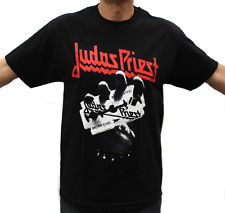

In [43]:
# Motorhead T-Shirt
#url = 'https://images.backstreetmerch.com/images/products/bands/clothing/mthd/bsi_mthd281.jpg'
# Judas Priest T-Shirt
#url = 'https://thumbs2.ebaystatic.com/d/l225/m/m7Lc1qRuFN3oFIlQla5V0IA.jpg'
# Iron Maiden T-Shirt
#url = 'https://www.ironmaidencollector.com/assets/pages/ab9ed-20180815_121042.jpg'
# All Blacks rugby jersey
#url = 'https://images.sportsdirect.com/images/products/38153703_l.jpg'
# Australia Rugby T-Shirt
#url = 'https://www.lovell-rugby.co.uk/products/products_580x387/40378.jpg'
# Chicago Bulls top
#url = 'https://i.ebayimg.com/images/g/qc0AAOSwBahVN~qm/s-l300.jpg'
# Masters Golf Shirt
#url = 'https://s-media-cache-ak0.pinimg.com/originals/29/6a/15/296a15200e7dd3ed08e12d9052ea4f97.jpg'
img_bytes = requests.get(url).content
img = Image.open(BytesIO(img_bytes))
img

In [44]:
response = predictor.predict(img_bytes)
response

{'class': 'metal', 'confidence': 0.9999873638153076}

### Cleanup endpoint

When you're done with the endpoint, you should clean it up.

All of the training jobs, models and endpoints we created can be viewed through the SageMaker console of your AWS account.

In [45]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: sagemaker-pytorch-2018-12-15-19-03-54-512
